--------------------------------------------------------------------------------------

* Team member names: Kevin Wong, Lukas Fullner
* Team member IDs: A17280855, A16945107

--------------------------------------------------------------------------------------

# Mini-project 4, DSC 170, Winter 2025

# Suitability Modeling

This project will focus on __suitability analysis__ with raster data. Your tasks will be both conceptual-level and technical. 

There are three parts to this assignment.

1. At the conceptual level, you will define a suitability model of your choice, for an area of your choice (preferably San Diego, because we already have worked with some local data). Consult the lectures on map combination, and also see https://pro.arcgis.com/en/pro-app/latest/help/analysis/spatial-analyst/suitability-modeler/the-general-suitability-modeling-workflow.htm for a brief description of what a suitability model is. For example, you may be looking for best areas for community gardens. Such areas are often selected from underutilized land in residential land uses, with good soils, good drainage, accessible (not steep slope), etc. So you would be looking for areas with a specific type of land use/land cover, with an appropriate range of values of slope, etc. You may build additional criteria based on a range of precipitaiton values, whether the area is affected by wildfires, or has low levels of soil erosion, etc. Feel free to use the imagery layers we explored or mentioned during raster-focused lectures. Several cells in lecture notebooks contained URLs to imagery layer collections available through AGOL - but feel free to find more. Also, feel free to download additional raster layers from elsewhere (an example in lecture demonstrates how to do this from the USGS image repository, and also how to get Sentinel-2 from ESA), publish them on ArcGIS Enterprise, and use in your model. 

You can use any __two__ of the <i>map combination</i> techniques discussed during lectures. You should identify the ones you use and discuss any uncertainty issues associated with these specific map combination models. 

As the outcome of this part, you will need to: a) describe the suitability model you want to develop; b) identify the raster data layers you will use; and c) describe two of the map combination techniques you will use to derive the two suitablity maps, and their pros and cons.

2. The second part will involve implementing your suitability model using arcgis raster functions. Many of these functions are new and experimental! Examples of what works are in the lecture notebooks. Be creative!    

3. The third part will be a brief write-up comparing the two output rasters generated for the suitability models using the two map combination techniques. 

The notebook should include documentation of the steps, as usually.



**Due Date: 03/01/2025 11:59PM (Pacific Time)**

**Total Possible Points: 30 Pts**

## Task 1: Formulate a suitability or risk model (5 points)

Your text here (about 100 words)

To help identify possible locations for public parks in San Diego, we could look at a few options, including Population Density and Demographics (Areas with high population density and little park access), neighborhoods with more seniors and children, and more. We could also look at park distribution (areas beyond walking distance of parks), and check for availability of land in case we could repurpose public land. Some physical characteristics that we would typically look for would be flat lane (slope), decent soil quality, with good drainage and accessibility. Additionally, we could think about accessibility, with proximity to homes, public transportation, bike lanes, and walkability of the neighborhoods surrounding the area. 

Some map combination techniques we could use include a weighted linear combination to balance the social need of a community versus the physical suitability of the land. We could also use Boolean Overlay to help determine areas that aren't risk to fires or floods, which would help narrow down areas that we would like to use.

## Task 2: Implement the model (20 points)

In [1]:
# Imports, etc.
import arcgis
import arcgiskey
from arcgis.gis import GIS
from arcgis.geometry import *
from arcgis.raster.functions import *
from ipywidgets import *
import graphviz
from IPython.display import display
from arcgis.raster.functions import stretch

gis = GIS(username = arcgiskey.USERNAME, password = arcgiskey.PASSWORD)

In [61]:
# List imagery layers to be used in your model. 
# This cell should contian layer definitions.
usa_landcover_gap = ImageryLayer(
    "https://landscape3.arcgis.com/arcgis/rest/services/USA_Landcover_GAP/ImageServer",
    gis,
)
usa_soil_erosion = ImageryLayer(
    "https://landscape11.arcgis.com/arcgis/rest/services/USA_Soils_Erosion_Class/ImageServer",
    gis,
)
usa_soil_erodibility = ImageryLayer(
    "https://landscape11.arcgis.com/arcgis/rest/services/USA_Soils_Erodibility_Factor/ImageServer",
    gis
)
usa_elevation = ImageryLayer(
    "https://elevation.arcgis.com/arcgis/rest/services/WorldElevation/Terrain/ImageServer",
    gis,
)
usa_federal_lands = ImageryLayer(
    "https://landscape10.arcgis.com/arcgis/rest/services/USA_Federal_Lands/ImageServer",
    gis,
)
usa_flood_hazard = ImageryLayer(
    "https://landscape11.arcgis.com/arcgis/rest/services/USA_Flood_Hazard_Areas/ImageServer",
    gis,
)


In [68]:
usa_soil_erodibility.properties

{
  "currentVersion": 10.81,
  "serviceDescription": "This service is available to all ArcGIS Online users with organizational accounts. For more information on this service, including the terms of use, visit us online at <a href='https://goto.arcgisonline.com/landscape11/USA_Soils_Erodibility_Factor'> https://goto.arcgisonline.com/landscape11/USA_Soils_Erodibility_Factor</a>.",
  "name": "USA_Soils_Erodibility_Factor",
  "description": "This service is available to all ArcGIS Online users with organizational accounts. For more information on this service, including the terms of use, visit us online at <a href='https://goto.arcgisonline.com/landscape11/USA_Soils_Erodibility_Factor'> https://goto.arcgisonline.com/landscape11/USA_Soils_Erodibility_Factor</a>.",
  "extent": {
    "xmin": -20037507.0672,
    "ymin": -1617169.7091000006,
    "xmax": 20037507.842788246,
    "ymax": 11560120.2909,
    "spatialReference": {
      "wkid": 102100,
      "latestWkid": 3857
    }
  },
  "initialEx

In [72]:
county_layer.query().sdf

,OBJECTID,NAME,STATE_NAME,STATE_FIPS,FIPS,SQMI,POPULATION,POP_SQMI,STATE_ABBR,COUNTY_FIPS,Shape__Area,Shape__Length,SHAPE
0,1,Grand Forks County,North Dakota,38,38035,51.3,73170,50.8,ND,035,0.45037,2.961625,"{""rings"": [[[-96.8894256235004, 47.67392519197..."
1,2,Grant County,North Dakota,38,38037,1.4,2301,1.4,ND,037,0.504068,3.413506,"{""rings"": [[[-102.003385812939, 46.05284759773..."
2,3,Griggs County,North Dakota,38,38039,3.1,2306,3.2,ND,039,0.223034,1.949037,"{""rings"": [[[-97.9616729885937, 47.24493801330..."
3,4,Hettinger County,North Dakota,38,38041,2.1,2489,2.2,ND,041,0.342747,2.691898,"{""rings"": [[[-102.003371825849, 46.20580311678..."
4,5,Kidder County,North Dakota,38,38043,1.6,2394,1.7,ND,043,0.437806,2.719487,"{""rings"": [[[-100.088490419176, 46.63570178753..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3139,3140,Gilmer County,West Virginia,54,54021,21.8,7408,21.8,WV,021,0.091543,1.362677,"{""rings"": [[[-80.9851207208188, 38.72226549952..."
3140,3141,Grant County,West Virginia,54,54023,22.4,10976,22.9,WV,023,0.129571,1.869941,"{""rings"": [[[-79.3505059021962, 38.94885237924..."
3141,3142,Greenbrier County,West Virginia,54,54025,31.2,32977,32.2,WV,025,0.273052,2.749,"{""rings"": [[[-80.7901317149683, 37.86641650649..."
3142,3143,Hampshire County,West Virginia,54,54027,36.0,23093,35.8,WV,027,0.173102,1.803586,"{""rings"": [[[-78.3475464916962, 39.45699820239..."


In [73]:
# Derive the area of interest (AOI) and its geometry and extent. 
# The smaller the area the better (so that you don't run into raster size limitations)

# set the geometry and boundary extent for San Diego county specifically
counties = gis.content.search("USA Counties generalized", "Feature Layer", outside_org=True)[4]
county_layer = counties.layers[0]
county = county_layer.query("NAME = 'San Diego County'", return_geomtry = True)
san_diego_geometry = county.features[0].geometry
san_diego_geometry['spatialRef'] = san_diego_geometry['spatialReference']
san_diego_projected = project(
    [san_diego_geometry],
    in_sr=san_diego_geometry["spatialReference"],
    out_sr={"wkid": 102100},
)[0]

san_diego_extent = Geometry(san_diego_projected).geoextent

# create the extent as a tuple
tup = (
    ("xmin", san_diego_extent[0]),
    ("ymin", san_diego_extent[1]),
    ("xmax", san_diego_extent[2]),
    ("ymax", san_diego_extent[3]),
)
sd_ex = dict(tup)

# 2d: to be correcter, let's also add CRS:
crs = "{'latestwkid':3857, 'wkid':102100}"
sd_ex.update({"spatialReference": {"latestwkid": 3857, "wkid": 102100}})

In [103]:
# Set the extent if needed
# San Diego Land Cover Gap
usa_landcover_gap.extent = sd_ex
sd_lcg = clip(usa_landcover_gap, san_diego_geometry)

# USA Soil Erosion
usa_soil_erosion.extent = sd_ex
sd_se = clip(raster = usa_soil_erosion, geometry = san_diego_geometry)

# USA Soil Erodibility
usa_soil_erodibility.extent = sd_ex
sd_er = clip(raster = usa_soil_erodibility, geometry = san_diego_geometry)

# USA Elevation
usa_elevation.extent = sd_ex
sd_elev = clip(raster = usa_elevation, geometry = san_diego_geometry)

# USA Federal Lands
usa_federal_lands.extent = sd_ex
sd_fl = clip(raster = usa_federal_lands, geometry = san_diego_geometry)

# USA Flood Hazard
usa_flood_hazard.extent = sd_ex
sd_fh = clip(raster = usa_flood_hazard, geometry = san_diego_geometry)

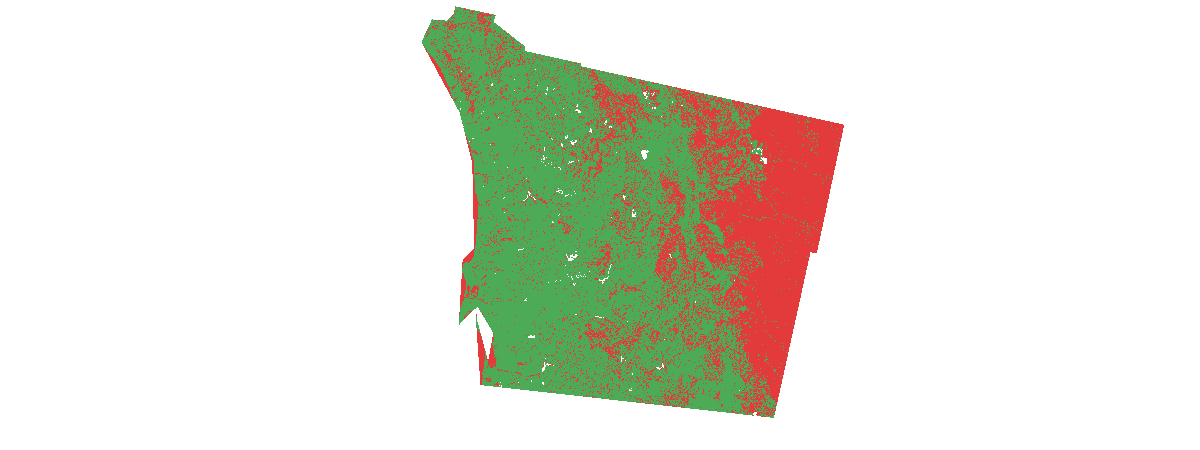

In [104]:
# Remap and Normalize the Outputs of each layer
# Remap the Land Cover Gap layer
# For the Land Cover Gaps, we will remap the values to the following classes:
# Shrubland & Grassland, Agricultural Vegatation, Introduced & Semi Natural Vegatation, Recently Disturbed or Mofidified, and Developed & Other Human Use to Green
# Forest & Woodland, Semi_deset, Polar & High Montane Vegetation Vegatation, Aquatic Vegetation, and Nonvascular * Sparse Vacular Rock Vegetation & Opem Water to Red
clrmap2 = [[0, 227, 59, 59], [1, 77, 170, 87]]
sd_lcg_norm = remap(
    raster=sd_lcg,
    input_ranges=[1.0,289.0, 290.0,459.0, 460.0,499.0, 500.0,507.0, 508.0,513.0,
                   514.0,554.0, 555.0,557.0, 558.0,563.0, 564.0,576.0,
                     577.0,579.0, 580.0,585.0],
    output_values=[0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1],
    astype='U8'
)
sd_lcg_binary = colormap(sd_lcg_norm, colormap=clrmap2)
sd_lcg_binary

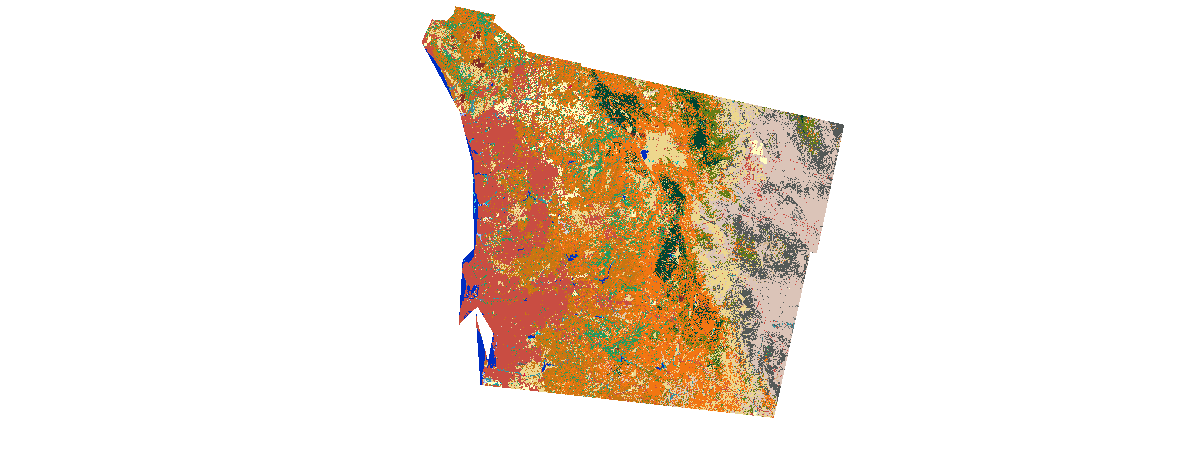

In [110]:
sd_lcg

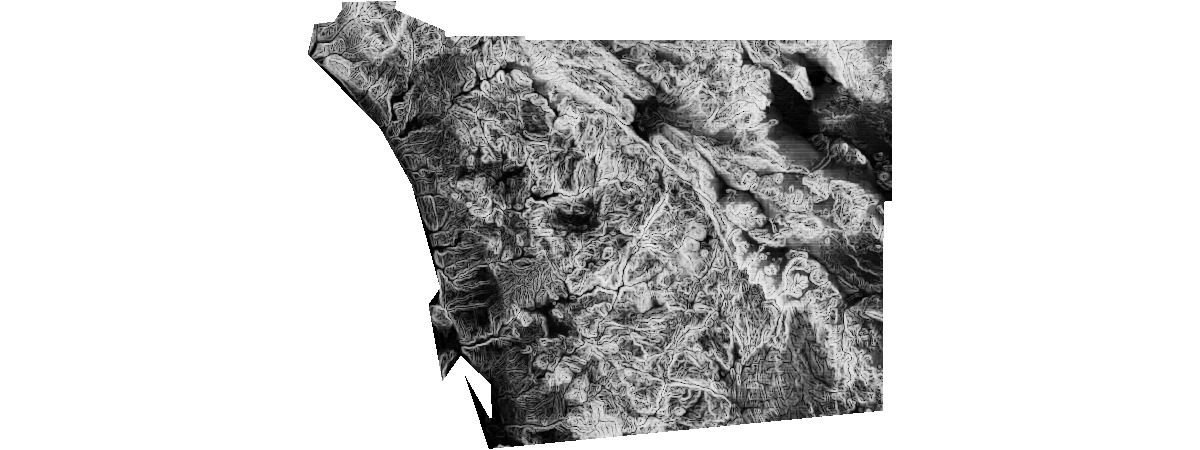

In [106]:
# Create the Slope Layer from Elevation
slope_lyr = slope(dem=sd_elev, slope_type='DEGREE', z_factor=10)
slope_lyr

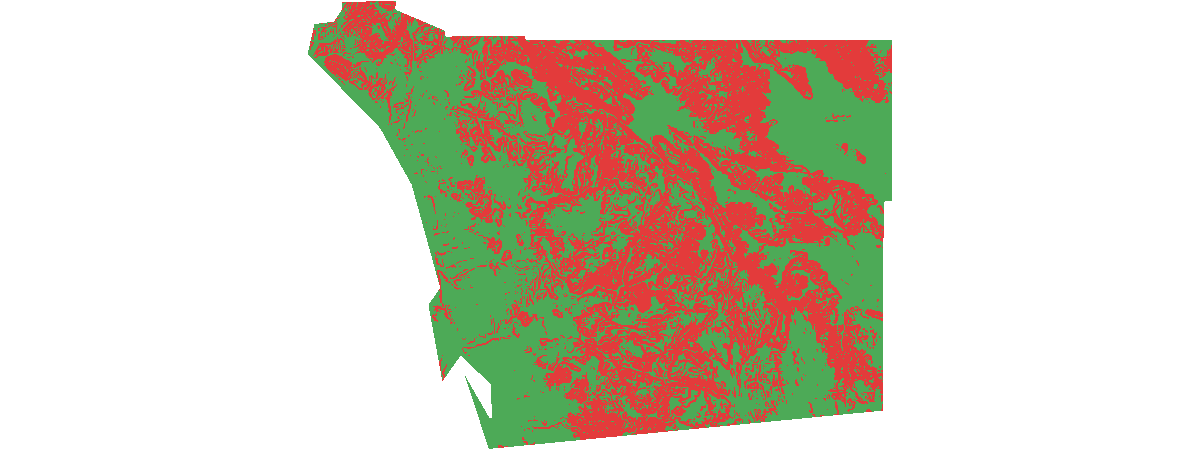

In [107]:
# define a slope cutoff for binary usage
mid = 45 #Slope cutoff (in degrees)

slope_binary = remap(
    raster=slope_lyr,
    input_ranges=[-450,mid, mid,8700],
    output_values=[1, 0],
    astype='U8'
)
slope_b_c = colormap(slope_binary, colormap=clrmap2)
slope_b_c

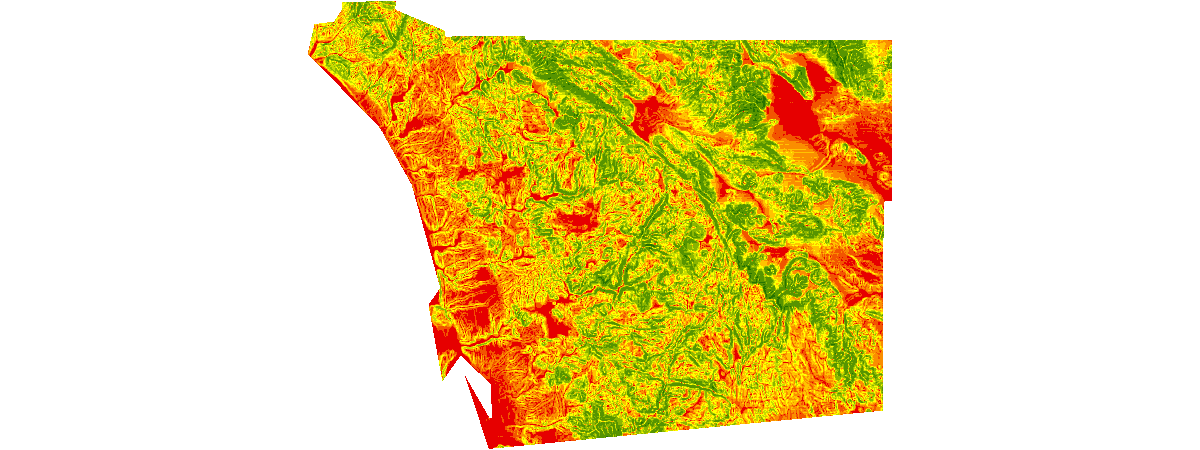

In [108]:
# define a slope rule for non-binary usage
clrmap9 = [[9, 230, 0, 0], [8, 242, 85, 0], [7, 250, 142, 0], [6, 255, 195, 0], [5, 255, 255, 0], [4, 197, 219, 0],  
          [3, 139, 181, 0], [2, 86, 148, 0], [1, 38, 115, 0]]

slope_bands = remap(
    raster=slope_lyr,
    input_ranges=[-450,10, 10,20, 20,30, 30,40, 40,50, 50,60, 60,70, 70,80, 80,8700],
    output_values=[9, 8, 7, 6, 5, 4, 3, 2, 1],
)
slope_banded = colormap(slope_bands, colormap=clrmap9)
slope_banded

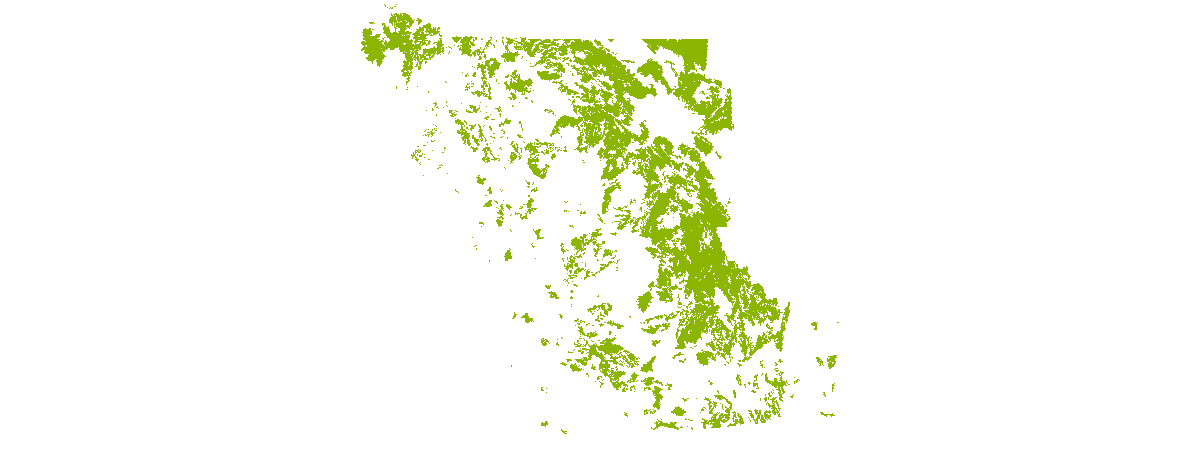

In [115]:
# map the errosion level of the soil to both a binary and non-binary set of rules
clrmap5 = [[9, 230, 0, 0], [7, 250, 142, 0], [5, 255, 255, 0], [3, 139, 181, 0], [1, 38, 115, 0]]

#map each errosion level to a band
erroded_norm = remap(
    raster=sd_se,
    input_ranges=[0.5,1.5, 1.5,2.5, 2.5,3.5, 3.5,4.5, 4.5,5.5],
    output_values=[5, 4, 3, 2, 1],
)
er_bands = colormap(erroded_norm, colormap=clrmap5)
er_bands

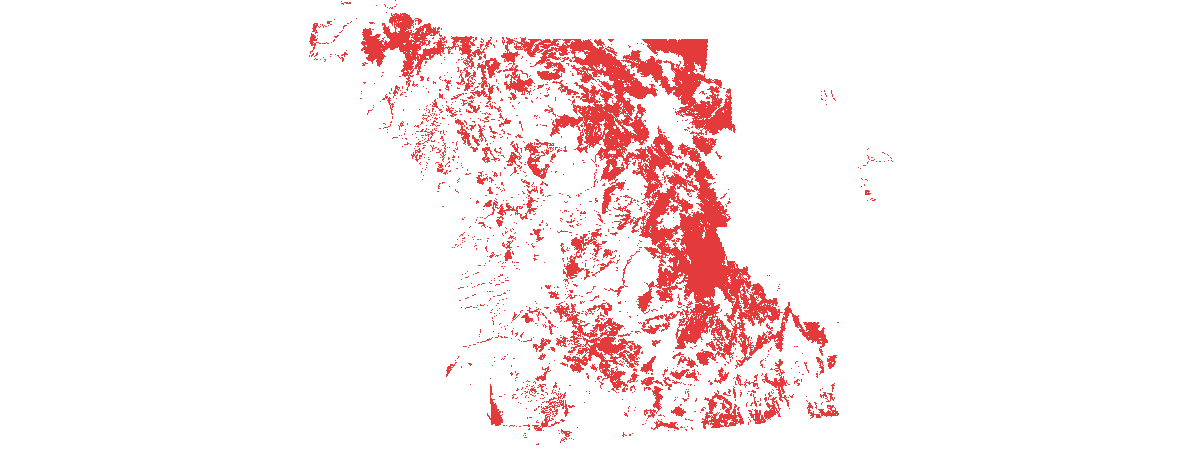

In [117]:
# mapping all errosion levels to 1 to exclude any area with errosion (could change it to allow 1-25% if its not an issue)
erroded_binary = remap(
    raster=sd_se,
    input_ranges=[1, 1, 1, 2, 2, 3, 3, 4, 4, 5],
    output_values=[0, 0, 0, 0, 0],
    astype="U8",
)
er_binary = colormap(erroded_binary, colormap=clrmap2)
er_binary

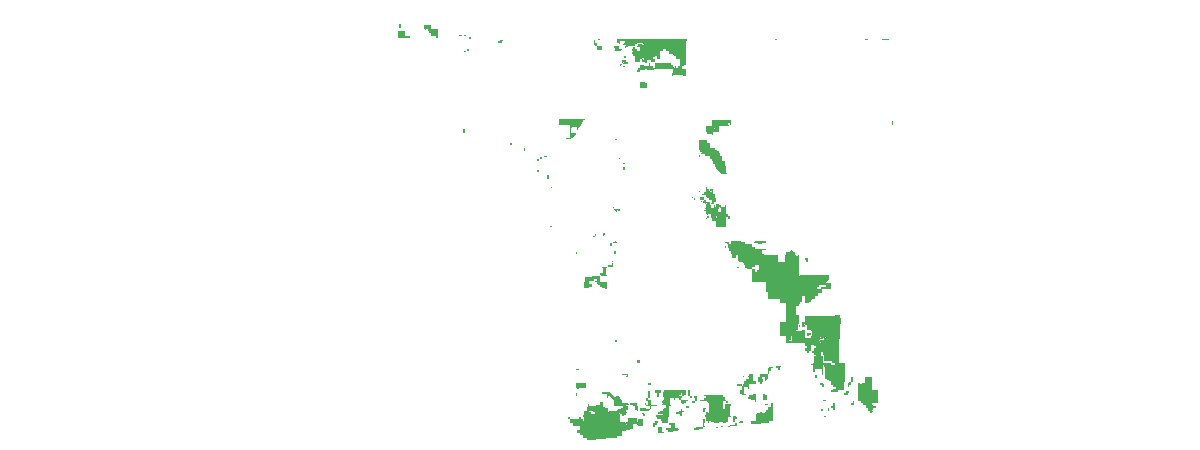

In [118]:
#mapping all flooded locations to 0
federal_binary = remap(
    raster=sd_fl,
    input_ranges=[0,1,1,1],
    output_values=[0, 1],
    astype='U8'
)
federal_b = colormap(federal_binary, colormap=clrmap2)
federal_b

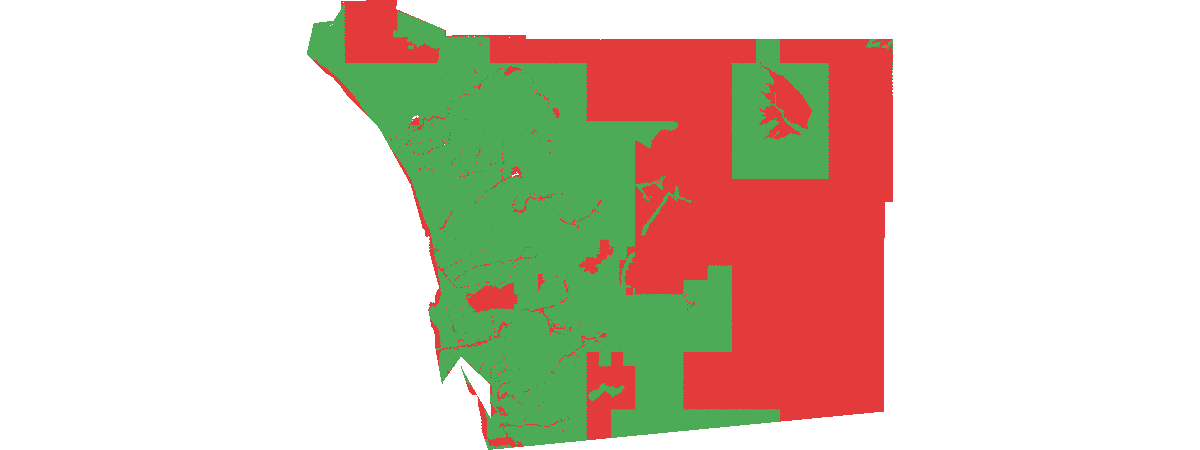

In [119]:
# Apply the remap functiond

# 0 - Low Flood Hazard
# 1 - 1% Annual Flood Hazard, Other
sd_fh_normalized = remap(
    raster=sd_fh,
    input_ranges=[4,5, 12,13, 13,14, 15,16, 18,19, 30,31, 27,28, 40,41, 46,47, 49,50, 54,55, 59,60, 77,78, 81,82, 233,244],
    output_values=[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    allow_unmatched=False,
    astype='U8'
)
sd_fh_binary = colormap(sd_fh_normalized, colormap=clrmap2)
sd_fh_binary

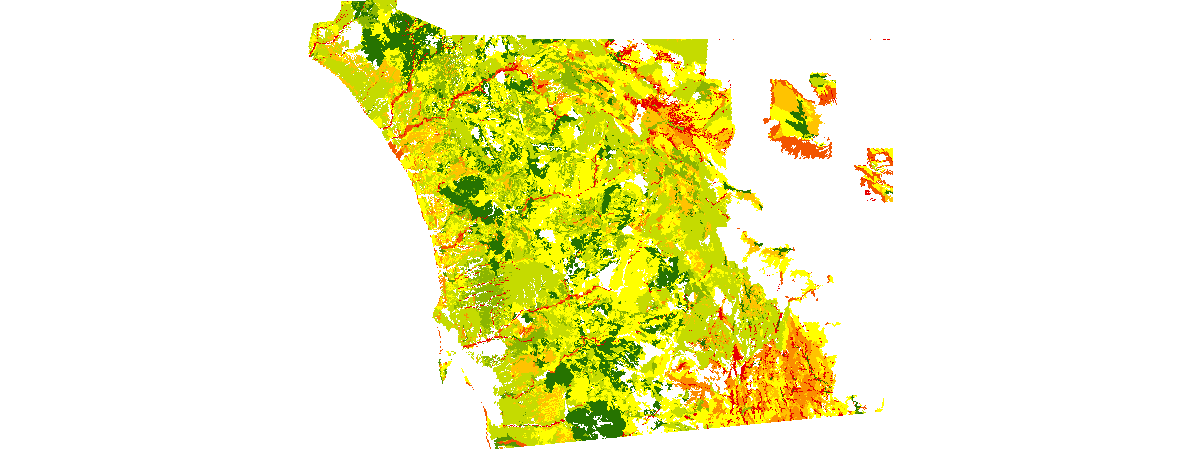

In [121]:
# remap the soil erodibility layer in binary and non-binary layers
soil_normalized = remap(
    raster=sd_er,
    input_ranges=[
        0.0,
        8.0,
        8.0,
        13.0,
        13.0,
        18.0,
        18.0,
        23.0,
        23.0,
        28.0,
        28.0,
        33.0,
        33.0,
        38.0,
        38.0,
        43.0,
        43.0,
        64.0,
    ],
    output_values=[9, 8, 7, 6, 5, 4, 3, 2, 1],
)
soil_n_c = colormap(soil_normalized, colormap=clrmap9)
soil_n_c

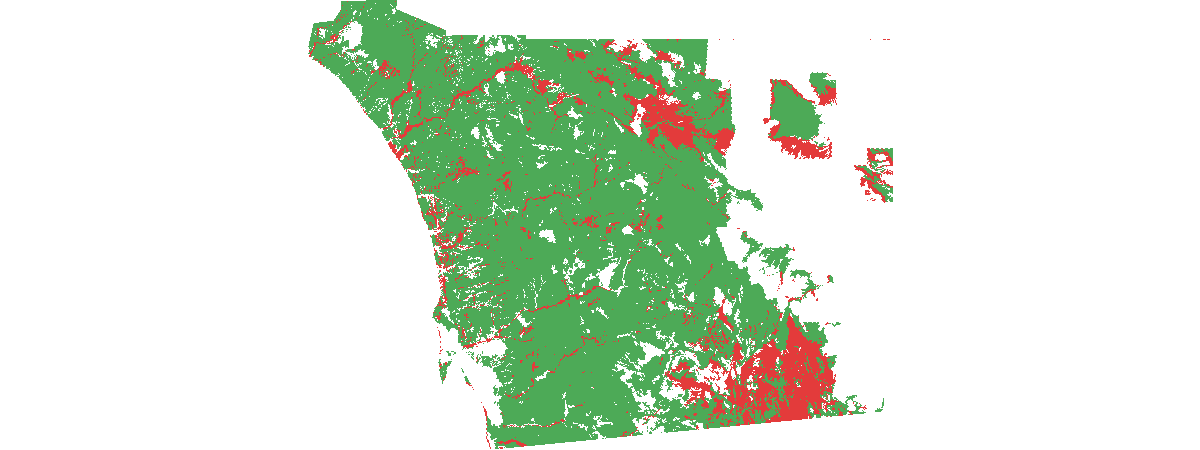

In [122]:
soil_binary = remap(
    raster=sd_er,
    input_ranges=[0.0, 20.0, 20.0, 65.0],
    output_values=[0, 1],
    astype="U8",
)
soil_b_c = colormap(soil_binary, colormap=clrmap2)
soil_b_c

### Name the two map combination techniques you will use to combine the data and describe their pros and cons

The two map combination techniques we will have use to combine the data are
1) Exclusion Screening: We want areas that have good soil (1 or 0), low soil erodibility (1 or 0), low flood risk (1 or 0), a flat slope (1 or 0), and land area that is suitable for building a park (already defined in sd_lcg_binary, 1 or 0). To do this, let's use exclusionary screening to multiple 1s and 0s.
2) Weighted Voting: We can also use the weighted voting contribution with our binary and non-binary attributes to determine which ImageryLayers are most important for a good park. For instance, we could weight having a flat slope and low flood risk as the most important features, and then the other layers can be supplementary to determine better locations.

In [27]:
from arcgis.raster.functions import raster_calculator
from arcgis.raster.functions import extract_band

In [28]:
# Generate a composite raster layer for your first map combination technique
# land cover gap (1 is usable land, 0 is non-usable land)
lcg_band = extract_band(sd_lcg_binary, [0])  
# slope (1 is flat land, 0 is steep land)
slope_binary_band = extract_band(slope_binary, [0])
# errosion (1 is non-erroded land)
er_binary_band = extract_band(er_binary, [0])
# flood hazards (1 is low risk land, 0 is risky land)
fh_band = extract_band(sd_fh_normalized, [0])
# soil erodibility (1 is land w/low erodibility, 0 has higher chance of errosion)
soil_b_band = extract_band(soil_binary, [0])

In [47]:
result1 = raster_calculator(
    rasters=[lcg_band, fh_band],  # list of rasters
    input_names=["cover", "flood"],  # variable names to use in expression
    expression="(cover) + (flood)",  # the arithmetic expression
    # extent_type = "UnionOf",
    #cellsize_type = "MaxOf",
    astype = "C128"
)

In [41]:
res_out2 = arithmetic(
    lcg_band,
    slope_binary_band,
    # extent_type="FirstOf",
    # cellsize_type="FirstOf",
    astype="U8",
    operation_type=1,
)


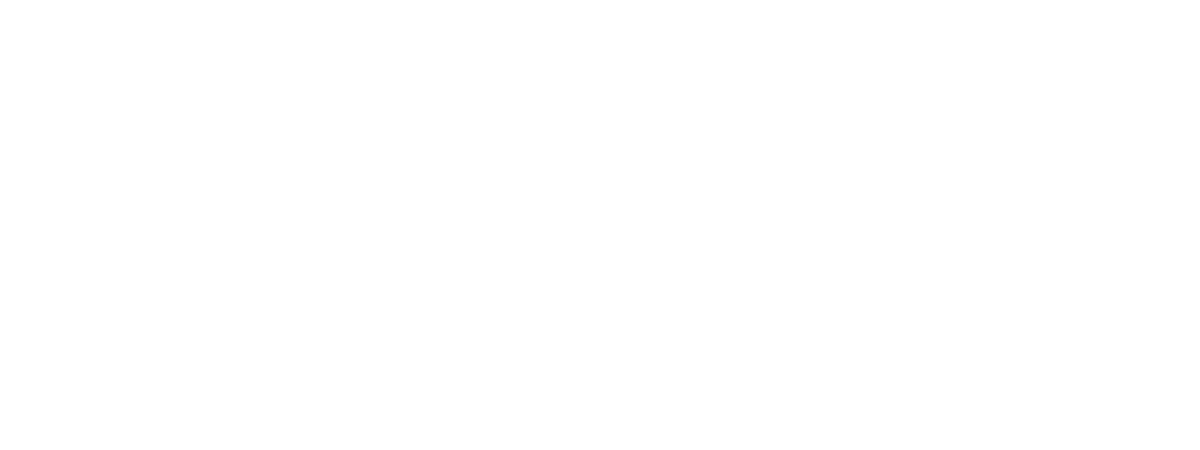

In [42]:
res_out2

In [43]:
map6 = gis.map("San Diego County, CA")
map6.content.add(res_out2)
map6

Map(center=[3899047.926834046, -12998800.702954108], extent={'xmin': -13068598.023681488, 'ymin': 3816090.6311…

In [173]:
print(slope_binary_band.properties.minValues)
print(slope_binary_band.properties.maxValues)

[-450]
[8700]


In [48]:
result1.raster_info

{'extent': {'xmin': -2290889.2101138067,
  'ymin': -1726385.2485951362,
  'xmax': 2198700.7898861933,
  'ymax': 1472154.7514048638,
  'spatialReference': {'wkid': 102008, 'latestWkid': 102008}},
 'bandCount': 1,
 'pixelType': 'S16',
 'pixelSizeX': 30,
 'pixelSizeY': 30}

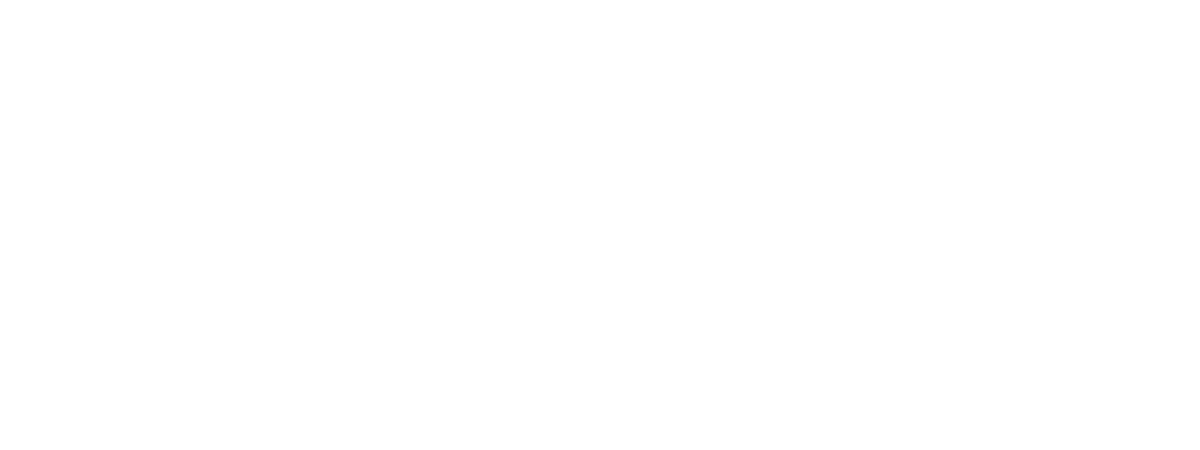

In [49]:
result1

In [50]:
map7 = gis.map("San Diego, CA")
map7.content.add(result1)
map7

Map(center=[3857636.3466711883, -13042616.481232138], extent={'xmin': -13075789.689488532, 'ymin': 3818273.910…

In [28]:
# Generate a composite raster layer for your second map combination technique


## Task 3: Compare the results (5 points)
... and describe how different combination techniques resulted in different outputs (or not.) 

Your text here


In [29]:
## Timekeeping
# Please let us know how much time you spent on this project, in hours: 
# (we will only examine distributions and won't look at individual responses)

assignment_timespent = 0